In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms as tfs
from transformers import ViTForImageClassification, ViTConfig
from tqdm.notebook import tqdm

In [22]:
torch.__version__

'2.5.1+cu118'

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 5
image_size = 224

cuda


In [24]:
train_transform = tfs.Compose([
    tfs.ToTensor(),
    tfs.RandomHorizontalFlip(),
    tfs.RandomCrop(32, padding=4),
    tfs.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    tfs.Resize((image_size, image_size))
]) 
test_transform = tfs.Compose([
    tfs.ToTensor(),
    tfs.Resize((image_size, image_size)),
    tfs.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [25]:
# load CIFAR10 dataset and pass it to a dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=5)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=5)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Create transformer model and load their weights from part 2 

In [ ]:
vit_pretrained = torch.load("./model_pretrained_42.pth")
patch_size = 4 # patch size for encoding
num_classes = 10 # num of classes

#ViT model for CIFAR-10
config = ViTConfig(
    image_size=image_size,  # Input image size
    patch_size=patch_size,  # Patch size for the 32x32 images
    num_labels=num_classes,  # Number of output classes
    hidden_size=256,  # Hidden size (smaller model for smaller images)
    num_hidden_layers=6,  # Fewer layers, since the image size is smaller
    num_attention_heads=8,  # Number of attention heads
    intermediate_size=512,  # Intermediate size of feedforward network
    hidden_dropout_prob=0.0,  # Dropout probability
    attention_probs_dropout_prob=0.0,  # Dropout on attention scores
)
vit_pretrained.config = config
vit_pretrained.eval()

C:\Users\wlavi\AppData\Local\Temp\ipykernel_8876\1723243073.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit_pretrained = torch.load("./model_pretrained_42.pth")


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [27]:
def test_model(model, test_data):
    print("Testing Model...")
    correct = 0
    predictions = []
    with torch.no_grad():
        for idx, (data, target) in enumerate(test_data):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.logits, 1)
            predictions.append(predicted)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / 10000
    print(f'Test Accuracy: {accuracy}%' )
    
    return accuracy, predictions

In [28]:
accuracy, predictions = test_model(vit_pretrained, testloader)

Testing Model...
Test Accuracy: 94.69%


Projection gradient descent attack:

$x^t_{adv} = \Pi_{\epsilon} (x^{t-1} + \alpha * sign(\nabla_x L(h(x^{t-1}), y ))) $

$x_{adv}$: adversarial image

x: input image

L: cost function

$ϵ$: noise magnitude. random noise from uniform distribution in range $(-ϵ, ϵ)$

h: model

$\nabla$: gradient


Fast gradient sign method (FGSM):

$x_adv = x + ϵ * sign(\nabla_xL(h(x,w), y))$

In [71]:
def denorm(batch, mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]):
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [38]:
def confusion_matrix(actuals, predictions, classes, title="Confusion Matrix", s=10):
    num_classes = len(classes)
    # actuals = []
    # predictions = []
    # #need to unroll dataloader and predictions
    # for idx, (_, labels) in enumerate(testloader):
    #     actuals.extend(labels.tolist())
    #     predictions.extend(predicted[idx])

    #create matrix
    mat = np.zeros((num_classes, num_classes))
    #print(len(predictions), len(actuals))
    for prediction, actual in zip(predictions, actuals):
        mat[prediction,actual] += 1

    #plot matrix
    fig, (ax1) = plt.subplots(ncols=1, figsize=(s, s))
    ax1.matshow(mat)
    
    # add the title and label
    ax1.set_title(title)
    ax1.set_xlabel('Actual Class')
    ax1.set_ylabel('Predicted Class')
    # set ticks to the classes
    ax1.set_xticks(np.arange(num_classes), labels=classes)
    ax1.set_yticks(np.arange(num_classes), labels=classes)

    for x in range(num_classes):
        for y in range(num_classes):
            ax1.annotate(int(mat[x,y]),xy=(x-0.2,y+0.1))

In [103]:
def PGDAttack(model, images, labels, eps, a=0.01, iters=4):
  """
  given an example of (x, y), return a set of adversarial examples within
  epsilon of x in l_infinity norm
  Parameters:
    model: pre-trained model
    eps: epsilon to bound amount of perturbation
    a: learning rate
    x: actual input
    y: actual label
    iters: number of iterations
  """
  images=images+ 2*eps*torch.rand(images.shape, device=device)-eps # add random perturbation from -eps to eps
  images = images.clone().detach().to(torch.float).requires_grad_(True)
  labels = labels.clone().detach().to(device)
  
  # save the original images to project back to the valid image range
  ori_images = images.clone().detach()

  for i in range(iters):
      # Forward pass
      outputs = model(images)
      loss = nn.CrossEntropyLoss()(outputs.logits, labels)
      
      # Backward pass
      model.zero_grad()
      loss.backward()
      
      # Perturb the images with a small step (alpha) in the direction of the gradient
      adv_images = images + a * images.grad.sign()
      
      # Ensure the perturbations are within the specified epsilon range
      eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
      images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
      images.requires_grad = True  # Re-enable gradients for the next iteration

  return images

In [ ]:
# run PGD and evaluate the model 
eps = [0.001, 0.005, 0.01, 0.05]
torch.cuda.empty_cache()
adv_images = []
predictions=[]
for ep in eps:
    correct=0
    prediction=[]

    print(f"Running epsilon={ep}")
    for i, (test_images_set , test_labels_set) in enumerate(testloader):
        test_images_set = denorm(test_images_set.to(device))
        adv_images_set = PGDAttack(vit_pretrained, test_images_set, test_labels_set, ep)
        
        outputs = vit_pretrained(adv_images_set)
        _, predicted = torch.max(outputs.logits, 1)
        
        # save only the 0-th batch of images for each epsilon value
        # since shuffling is false for testloader, these should be the same images
        if i==0:
            adv_images_set = denorm(adv_images_set)
            adv_images.append((test_labels_set, predicted, adv_images_set.detach() ))

        test_labels_set = test_labels_set.to(device)
        correct += (predicted == test_labels_set).sum().item()
        prediction.extend(predicted.tolist()) # save the predictions for CM
    
    predictions.append(prediction)    
    accuracy = 100 * correct / 10000
    print(f'Test Accuracy: {accuracy}% with epsilon={ep}' )

# print(f"Overall accuracy {(number_corrects / number_samples)*100}%")

Running epsilon=0.001
Test Accuracy: 43.51% with epsilon=0.001
Running epsilon=0.005
Test Accuracy: 8.09% with epsilon=0.005
Running epsilon=0.01
Test Accuracy: 0.28% with epsilon=0.01
Running epsilon=0.05
Test Accuracy: 0.0% with epsilon=0.05


Display the undisturbed and attack images

In [33]:
# since testloader doesn't shuffle, the order of the actual labels stay the same 
actual_labels=[]
for idx, (_, labels) in enumerate(testloader):
        actual_labels.extend(labels.tolist())

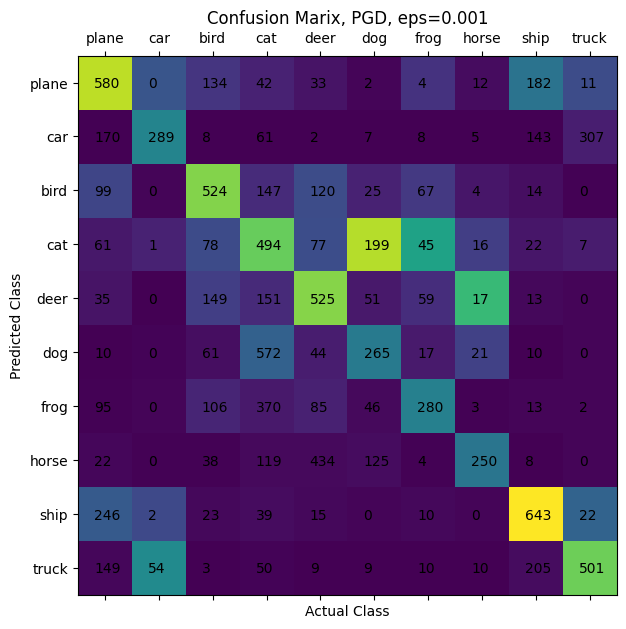

In [110]:
# confusion matrix for eps = 
confusion_matrix(actual_labels, predictions[0], classes,title="Confusion Marix, PGD, eps=0.001", s=7)

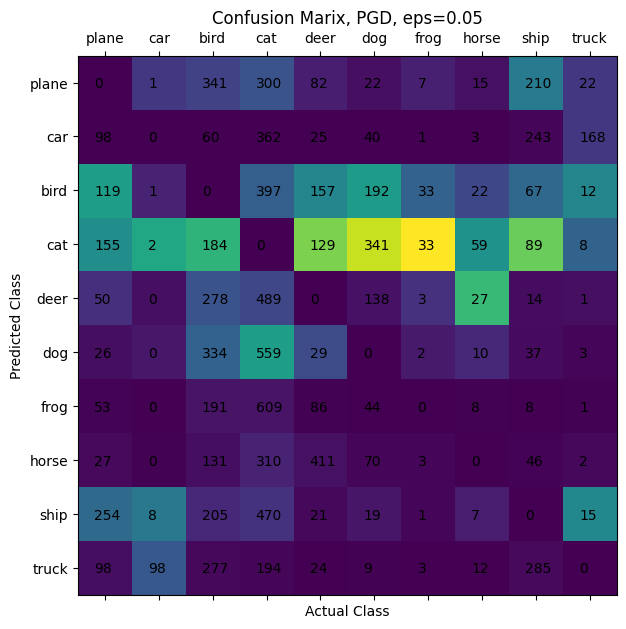

In [111]:
# confusion matrix for eps = 
confusion_matrix(actual_labels, predictions[-1], classes,title="Confusion Marix, PGD, eps=0.05", s=7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.96862745].


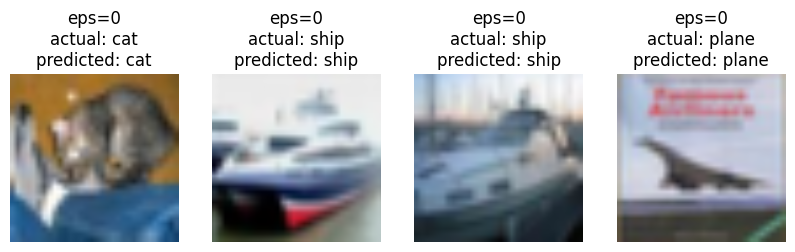

In [35]:
# adv_images_set = PGDAttack(vit_pretrained, img, labels, 0.01)
# outputs = vit_pretrained(adv_images_set)
# _, predicted = torch.max(outputs.logits, 1)

# grab the first 4 images from testloader to display
img, labels = next(iter(testloader))
img=img.to(device)
pred = vit_pretrained(img)
imgs = denorm(img)
actual = torch.max(pred.logits, 1)

fig, ax = plt.subplots(1, 4, figsize=(10, 20))

for i in range(4):
    ax[i].axis("off")
    ax[i].imshow(imgs[i].cpu().permute(1, 2, 0))
    ax[i].set_title(f"eps=0\nactual: {classes[labels[i]]}\npredicted: {classes[int(actual.indices[i])]}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04956555..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.052405827..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.038956188..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


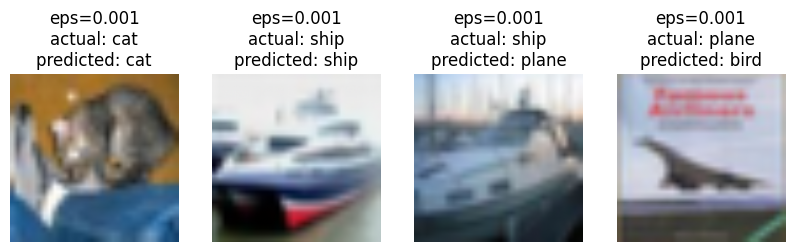

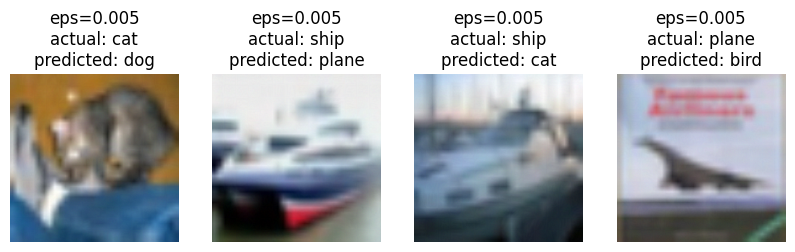

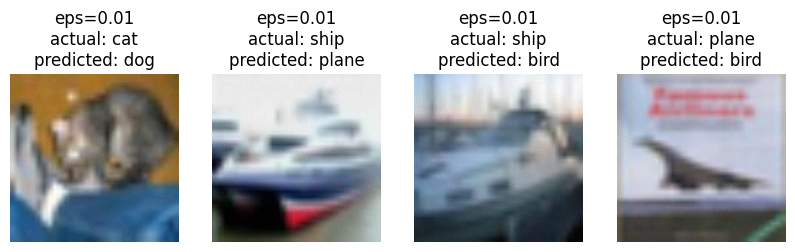

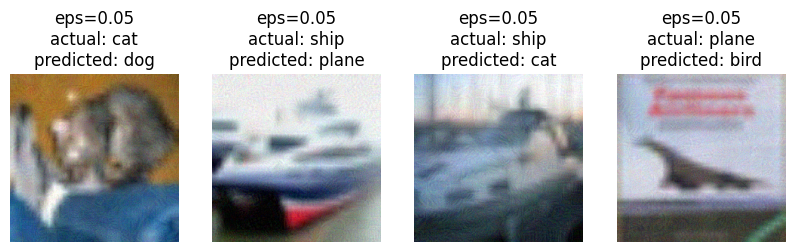

In [105]:
for i, ep in enumerate(eps):

    fig, ax = plt.subplots(1, 4, figsize=(10, 20))
    test_labels_set, predicted, adv_images_set = adv_images[i]
    for j in range(4):
        ax[j].axis("off")
        ax[j].imshow(tfs.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))(adv_images_set[j]).cpu().permute(1,2,0))
        ax[j].set_title(f"eps={ep}\nactual: {classes[test_labels_set[j]]}\npredicted: {classes[int(predicted[j])]}")


In [53]:
def fgsmAttack(model, images, labels, eps=0.03):
    images = images.clone().detach().to(torch.float).to(device).requires_grad_(True)
    labels = labels.clone().detach().to(device)

    # Forward pass
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs.logits, labels)

    # Backward pass
    model.zero_grad()
    loss.backward()

    # Generate adversarial images by adding perturbation in the direction of the gradient sign
    adv_images = images + eps * images.grad.sign()
    adv_images = torch.clamp(adv_images, min=0, max=1).detach()
    return adv_images


In [73]:
# attack and evaluate the model 
eps = [0.001, 0.005, 0.01, 0.05]
torch.cuda.empty_cache()
adv_images = []
predictions=[]
for ep in eps:
    correct=0
    prediction=[]

    print(f"Running epsilon={ep}")
    for i, (test_images_set , test_labels_set) in enumerate(testloader):
        test_images_set = denorm(test_images_set.to(device))
        
        adv_images_set = fgsmAttack(vit_pretrained, test_images_set, test_labels_set, ep)
        
        outputs = vit_pretrained(adv_images_set)
        _, predicted = torch.max(outputs.logits, 1)
        
        # save only the 0-th batch of images for each epsilon value
        # since shuffling is false for testloader, these should be the same images
        if i==0:
            adv_images_set = denorm(adv_images_set)
            adv_images.append((test_labels_set, predicted, adv_images_set.detach() ))

        test_labels_set = test_labels_set.to(device)
        correct += (predicted == test_labels_set).sum().item()
        prediction.extend(predicted.tolist())
    
    predictions.append(prediction)    
    accuracy = 100 * correct / 10000
    print(f'Test Accuracy: {accuracy}% with epsilon={ep}' )

# print(f"Overall accuracy {(number_corrects / number_samples)*100}%")

Running epsilon=0.001
Test Accuracy: 51.1% with epsilon=0.001
Running epsilon=0.005
Test Accuracy: 11.51% with epsilon=0.005
Running epsilon=0.01
Test Accuracy: 6.9% with epsilon=0.01
Running epsilon=0.05
Test Accuracy: 7.39% with epsilon=0.05


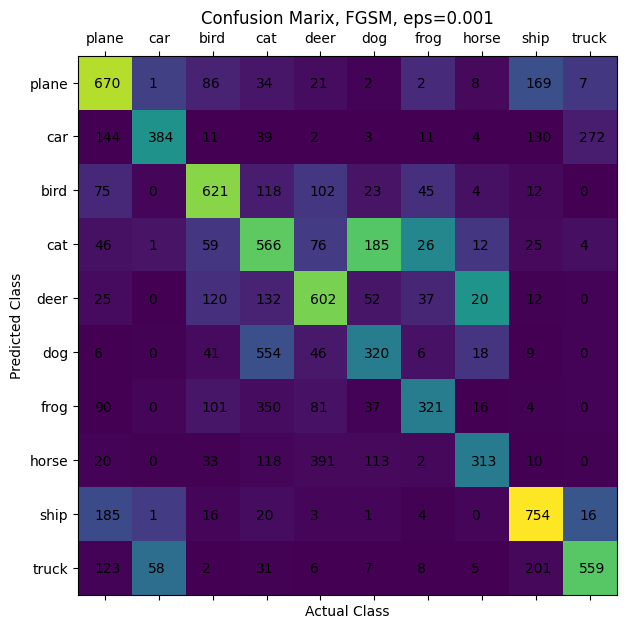

In [74]:
# confusion matrix for eps = 
confusion_matrix(actual_labels, predictions[0], classes,title="Confusion Marix, FGSM, eps=0.001", s=7)

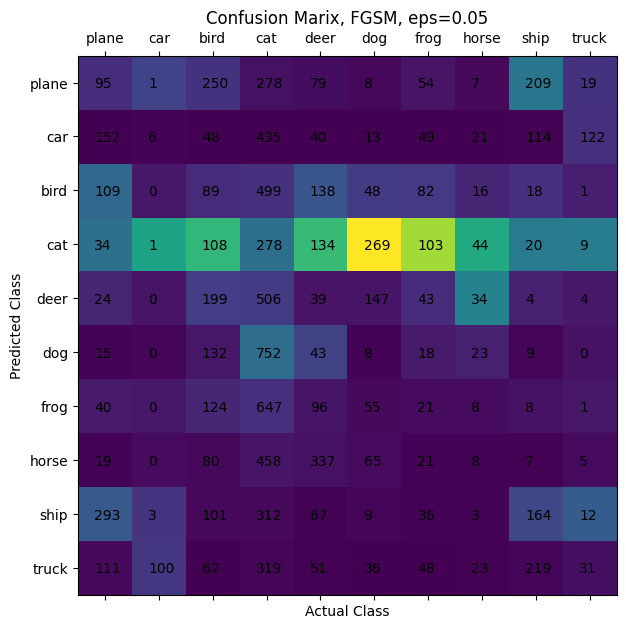

In [75]:
# confusion matrix for eps = 
confusion_matrix(actual_labels, predictions[-1], classes,title="Confusion Marix, FGSM, eps=0.05", s=7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.045980725..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.040980626..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0009806923..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


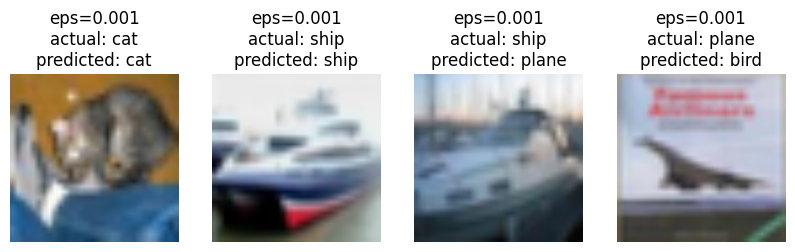

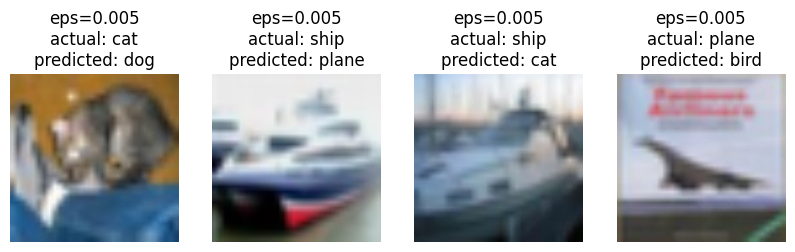

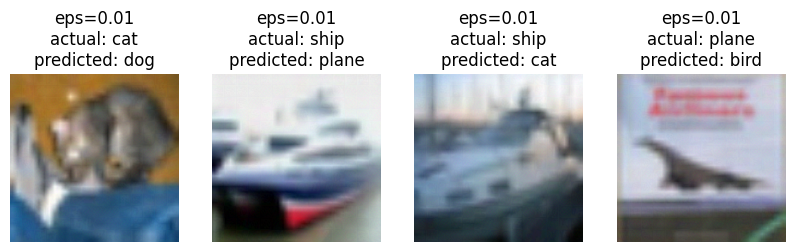

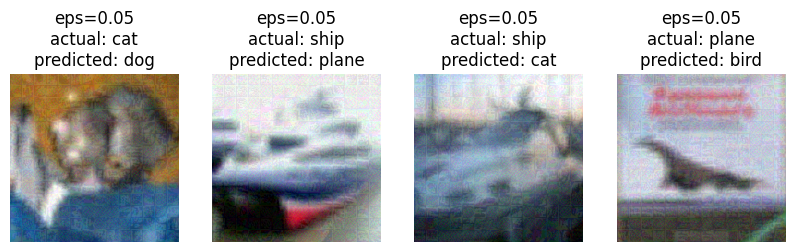

In [94]:
for i, ep in enumerate(eps):

    fig, ax = plt.subplots(1, 4, figsize=(10, 20))
    test_labels_set, predicted, adv_images_set = adv_images[i]
    # adv_images_set = adv_images_set.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    # test_transform(adv_images_set)
    for j in range(4):
        ax[j].axis("off")
        ax[j].imshow(tfs.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))(adv_images_set[j]).cpu().permute(1,2,0))
        ax[j].set_title(f"eps={ep}\nactual: {classes[test_labels_set[j]]}\npredicted: {classes[int(predicted[j])]}")
